In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.linear_model as linear_model
import datetime
from matplotlib import cm as cm
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesRegressor
from IPython.core.debugger import Tracer
from rpy2.robjects import pandas2ri
#%R install.packages('caret', repos='http://cran.us.r-project.org')
#%R install.packages('Boruta', repos='http://cran.us.r-project.org')

# Read data

In [2]:
x = pd.read_csv('X.csv',index_col=0)
y = pd.read_csv('y.csv',index_col=0)
cat = pd.read_csv('categorical.csv',index_col=0)

# Cleaning data

In [3]:
def cleandata(x, y, cat):
    '''Clean up NaN in x by: 
    1. removing columns that is the only NaN of the day (indicating bad quality of this column)
    2. removing days that is more than 1 NaN (probably a holiday)
    Corresponding days in y and cat are also removed to keep consistency.
    Removal of columns and rows happens in place, thus changed original x, y, cat.
    '''
    print 'Shape of x:',x.shape,'\n'
    
    if x.isnull().sum().sum()>0:
        # find NaN by day
        L = x.isnull().sum(axis=1)
        print 'No. of NaN by day (total',len(L[L>0]),'):'
        if (len(L[L>0]) > 0): print L[L>0]

        # identify days when only 1 column is NaN, and drop those columns
        print '\nDays when there is only 1 column being NaN:'
        dates = x.index[x.isnull().sum(axis=1)==1]
        C = [] # list of such columns

        for i in dates:
            C.append(x.columns[x.loc[i].isnull()].values)
            print i,C[-1]
        print '(total',len(C),')'

        if (len(np.unique(C)) > 0): 
            # It is recommended to remove columns in C because their bad quality
            x.drop(np.unique(C), axis=1, inplace=True)
            print '\nDropped column',np.unique(C)
        print ''

        # drop dates when there are multiple NaNs (probably holidays)
        D = x.index[x.isnull().sum(axis=1)!=0]
        print 'Drop days when there are multiple NaNs ( total',len(D),'):'
        if (len(D) > 0): print D.values
        x.drop(D, axis=0, inplace=True)
        y.drop(D, axis=0, inplace=True)
        cat.drop(D, axis=0, inplace=True)

        # examine x
        print '\nNew shape of x:',x.shape,'\n'
        # there should be no NaN in x now
        print 'No. of NaN (col & row-wise) in dataset x is:',x.isnull().sum().sum(),'\n'
    
    else:
        print 'There is no NaN in dataset x!\n'
    
    return x.isnull().sum().sum()==0

In [4]:
if(cleandata(x, y, cat)): 
    # process x & y to get day-to-day price change
    dx = x.diff()
    dx.drop(dx.index[0], inplace=True)
    
    dy = y.diff()
    dy.drop(dy.index[0], inplace=True)
    
    cat_new = cat.drop(cat.index[0])
    
    print 'Shape of dx:',dx.shape
    print 'Shape of dy:',dy.shape
    print 'Shape of cat_new:',cat_new.shape
else:
    print 'There is NaN in x!'  

Shape of x: (262, 444) 

No. of NaN by day (total 17 ):
Date
2015-01-06    440
2015-01-10      1
2015-01-20      1
2015-02-28      1
2015-03-26      7
2015-03-27    439
2015-04-18      1
2015-04-28    439
2015-05-05    439
2015-05-19    439
2015-06-23    439
2015-08-15    439
2015-08-18      1
2015-08-19      1
2015-09-29    439
2015-10-07      1
2015-11-04    443
dtype: int64

Days when there is only 1 column being NaN:
2015-01-10 ['x_72']
2015-01-20 ['x_72']
2015-02-28 ['x_72']
2015-04-18 ['x_438']
2015-08-18 ['x_72']
2015-08-19 ['x_72']
2015-10-07 ['x_72']
(total 7 )

Dropped column ['x_438' 'x_72']

Drop days when there are multiple NaNs ( total 10 ):
['2015-01-06' '2015-03-26' '2015-03-27' '2015-04-28' '2015-05-05'
 '2015-05-19' '2015-06-23' '2015-08-15' '2015-09-29' '2015-11-04']

New shape of x: (252, 442) 

No. of NaN (col & row-wise) in dataset x is: 0 

Shape of dx: (251, 442)
Shape of dy: (251, 4)
Shape of cat_new: (251, 2)


## examine y, noticed consecutive missing data in y_3

In [5]:
dy[dy.isnull().sum(axis=1)>0]

,y_0,y_1,y_2,y_3
Date,,,,
2014-12-02,NaN,NaN,NaN,NaN
2014-12-03,NaN,NaN,NaN,NaN
2014-12-12,-0.056561,0.112007,0.008544,NaN
2014-12-13,-0.097951,-0.036306,0.032826,NaN
2014-12-16,-0.001072,0.027727,-0.007644,NaN
2014-12-17,-0.090943,-0.108026,0.002634,NaN
2014-12-18,-0.149565,-0.012216,-0.005396,NaN
2014-12-19,0.008905,0.022717,0.020942,NaN
2014-12-20,-0.178010,-0.081123,-0.011627,NaN


## examine categorical

In [6]:
cat_new['CAT1'].value_counts()

5    68
1    59
3    50
7    47
2    12
6    10
4     5
Name: CAT1, dtype: int64

In [7]:
cat_new['CAT2'].value_counts()

7    76
1    66
5    59
3    37
2     8
6     5
Name: CAT2, dtype: int64

# preprocess routines

In [8]:
def drop_corr(dx, c=0.9):
    '''Drop highly correlated columns from dx using R package 'caret' function 'findCorrelation'. 
    c is the cutoff correlation level. 
    '''
    
    # activate rpy2 and load R library caret
    %load_ext rpy2.ipython
    %R library(caret)
    
    # input dx
    %R -i dx
    %R -i c
    #Tracer()()
    # get column correlation
    %R dx_cor <- cor(dx)
    # use findCorrelation function to select correlated columns
    %R I_cor <- findCorrelation(dx_cor, cutoff = c, verbose = FALSE, names = FALSE, exact = TRUE)
    # output index of correlated columns
    %R -o I_cor
    # print results
    print 'Dropped cols:',I_cor
    
    # process dx and output
    dx_new = dx.drop(dx.columns[I_cor-1], axis=1, inplace=False) # note index in R start with 1 instead of 0
    
    return dx_new

def select_boruta(x, y, max_runs=101):
    '''Select important columns in dx using R package boruta
    '''
    %R -i x
    %R -i y
    %R -i max_runs

    %R library(Boruta)
    %R set.seed(121)
    
    %R bor.results <- Boruta(x,y,maxRuns=max_runs,doTrace=0)
    
    %R print(bor.results)
    
    %R keepMe_short <- getSelectedAttributes(bor.results, withTentative = F)
    %R keepMe_long <- getSelectedAttributes(bor.results, withTentative = T)
    
    %R -o keepMe_short
    %R -o keepMe_long
    
    keepMe = {'short':keepMe_short,
            'long':keepMe_long}
    
    return keepMe


def preprocess(dx_train, dy_train, dx_test, dy_test, Ltype, N, func=f_regression, plot=False):
    '''Pre-process dx and retain a smaller number of candidate features.
    Using scikit.SelectKBest univariate model.
    Select function can be: f_regression or mutual_info_regression.'''
    
    dx_uncorr = drop_corr(dx_train, c=0.9)
    
    L = select_boruta(dx_uncorr, dy_train)
    
    dx_train_new = dx_train[L[Ltype]]
    dx_test_new = dx_test[L[Ltype]]
    
    ch = SelectKBest(func, k=min(N,dx_train_new.shape[1]))
    ch.fit(dx_train_new, dy_train)
    dx_selected = ch.transform(dx_train_new)
    dx_test = ch.transform(dx_test_new)
    col_selected = dx_train_new.columns[ch.get_support()]

    if plot:
        # examine std of each dx 
        plt.plot(range(N),pd.DataFrame(dx_selected).std(axis=0))
        plt.show()
    
    return dx_selected, dx_test, col_selected

In [9]:
def bootstrapping_byblock(dx, dy, cat, N_block, blocksize, same_cat):
    '''bootstrapping by block. 
    Block size is set to continuous days (normally 5 consecutive days).
    N_block is the number of blocks.'''
    
    ## Use datetime to find blocks. Blocks should start with D_last!=1 with following 1s
    # find the day difference between neighbouring records
    D_last = [(pd.to_datetime((dx.index[i+1]))-pd.to_datetime((dx.index[i]))).days for i in range(0,dx.shape[0]-1)]
    
    # assign block_id to each record
    N = 0
    L = [0]
    block_dic = dict()
    for i in range(1,dx.shape[0]):
        if (D_last[i-1] != 1):
            block_dic[N] = L
            N = N+1
            L = []
        L.append(i)
    block_dic[N] = L
    
    dx_new = pd.DataFrame(columns=dx.columns)
    dy_new = pd.Series()
    for i in range(N_block):
        n = pd.Series(range(N)).sample().values[0]
        I = block_dic[n]
        j = blocksize
        while ((j > 1) and (n < N-1)):
            I = I+block_dic[n+1]
            j = j-1
        
        if same_cat:
            newI = identical_cat(I, cat)
            dx_new = pd.concat([dx_new,dx.loc[newI,:]])
            dy_new = pd.concat([dy_new,dy.loc[newI]])
        else:
            dx_new = pd.concat([dx_new,dx.iloc[I,:]])
            dy_new = pd.concat([dy_new,dy.iloc[I]])
            
    return dx_new, dy_new, block_dic    

In [10]:
def identical_cat(I, cat):
    # sample from all dates with identical set of cat1 & cat2
    
    cat_group = cat.groupby(['CAT1','CAT2']).groups
    newI = [(pd.Series(cat_group[tuple(cat.iloc[I[i],:])]).sample()).iloc[0] for i in range(len(I))]
    
    return newI

In [11]:
def bootstrapping(dx, dy, cat, N_bs):
    '''bootstrapping with replacement according to identical cat.
    The output dx, dy is expanded by N_bs times.
    This function is not used but saved for the useful cat routines.''' 
    
    cat_group = cat.groupby(['CAT1','CAT2']).groups
    
    for i in range(N_bs):
        print 'bootstrapping round ',i
        x_add = pd.DataFrame(index=range(cat.shape[0]),columns=dx.columns)
        y_add = pd.Series(index=range(cat.shape[0]))
        
        for j in range(cat.shape[0]):
            # sample from all dates with identical set of cat1 & cat2
            ind_sample = (pd.Series(cat_group[tuple(cat.iloc[j,:])]).sample()).iloc[0]
            
            # retrieve records according to ind_sample
            x_add.iloc[j,:] = dx.loc[ind_sample]
            y_add.iloc[j] = dy.loc[ind_sample]
            
        dx = pd.concat([dx,x_add])
        dy = pd.concat([dy,y_add])       
    
    return dx, dy

In [12]:
def plotR2(R2_train, R2_test, maxN):
    '''plot adjusted R2 of training and testing dataset'''
    
    # set plot size and tick size
    plt.figure(figsize=(12,7))
    plt.tick_params(axis='both', which='major', labelsize=17)
    
    # plot training and testing datasets
    N = len(R2_train)
    p1, = plt.plot(range(1,N+1),R2_train,'b-*')
    p2, = plt.plot(range(1,N+1),R2_test,'r-*')
    
    # mark the data points corresponding to maxN
    plt.plot([maxN]*2,[0,np.max([R2_train[maxN-1],R2_test[maxN-1]])],'k--')
    plt.plot([0.5,maxN],[R2_train[maxN-1]]*2,'b--')
    plt.plot([0.5,maxN],[R2_test[maxN-1]]*2,'r--')
    plt.text(7,0.32,'Adj_R2 with '+str(maxN)+' elements:',fontsize=18)
    plt.text(7,0.25,'Train: '+str(round(R2_train[maxN-1],2)),fontsize=18)
    plt.text(7,0.2,'Test:  '+str(round(R2_test[maxN-1],2)),fontsize=18)
    
    # cosmetic
    plt.xticks(range(1,N+1))
    plt.title('Convergence of adjusted R2',fontsize=19)
    xlabel = 'No. of elements (max ' + str(maxN) + ')'
    plt.xlabel(xlabel,fontsize=17)
    plt.ylabel('Adjusted R2',fontsize=17)
    plt.ylim((0,1))
    plt.xlim((0.5,10.5))
    plt.legend([p1, p2], ['Train','Test'],fontsize=18,loc=4)
    
    plt.show()

In [13]:
def examine_features(dx, dy, plot, printout=True):
    '''Examine basket of dx to hedge dy using linear fit.
    plot and print R2 is optional. 
    Future work: compute t-stat and p values.'''
    
    if plot:
        plt.figure(figsize=(18, 16))
        plt.plot(range(dx.shape[0]),linear.predict(dx))
        plt.plot(range(dx.shape[0]),dy)
        plt.show()
    
    return R2_adj

In [14]:
def select_features(dx_selected, col_selected, dy_train, dx_test, dy_test, func='lassocv', a = 0.001, T=0.001, maxN=5, plot=False):
    '''Using scikit-learn.SelectFromModel with prefit.''' 
    
    N = 10
    
    # this list of selection function can be expanded
    if (func=='lasso'):
        # select features based on L1 (Lasso)
        # alpha needs to be tuned
        mod = linear_model.Lasso(alpha=a)
        mod.fit(dx_selected, dy_train)
        if (np.sum(abs(mod.coef_)>0) < 10):
            a = a/10
            mod = linear_model.Lasso(alpha=a)
            mod.fit(dx_selected, dy_train)
        selected_list = np.argsort(abs(mod.coef_))[-N:]
    elif(func=='lassocv'):
        # select features based on L1 (Lasso with 10-fold cross_validation)
        mod = linear_model.LassoCV(cv=10)
        mod.fit(dx_selected, dy_train)
        selected_list = np.argsort(abs(mod.coef_))[-N:]
    elif(func=='lassoIC'):
        mod = linear_model.LassoLarsIC()
        mod.fit(dx_selected, dy_train)
        selected_list = np.argsort(abs(mod.coef_))[-N:]
    elif(func=='ensemble'):
        # select features based on ensemble models
        mod = ExtraTreesRegressor()
        mod.fit(dx_selected, dy_train)
        selected_list = np.argsort(abs(mod.feature_importances_))[-N:]
    
    R2_train = [None] * N
    R2_test = [None] * N
    coeff = dict()
    for i in range(N):
        # fit linear regression model to the data with increasing number of features
        
        # apply a linear fit
        linear = linear_model.LinearRegression()
        linear.fit(dx_selected[:,selected_list[-i-1:]], dy_train)

        # compute adjusted R2 of training dataset
        R2 = linear.score(dx_selected[:,selected_list[-i-1:]], dy_train)
        R2_train[i] = 1-(1-R2)*(dx_selected.shape[0]-1)/(dx_selected.shape[0]-1-i-1)
        
        # compute adjusted R2 of testing dataset
        R2 = linear.score(dx_test[:,selected_list[-i-1:]], dy_test)
        R2_test[i] = 1-(1-R2)*(dx_test.shape[0]-1)/(dx_test.shape[0]-1-i-1)
        
        coeff[i] = linear.coef_
        
    n = np.argsort(R2_train[:maxN])[-1]+1
    print func,'selected ', n, ' features (ranked decreasingly important):', col_selected[selected_list[range(-1,-n-1,-1)]].values
    
    if plot:
        plotR2(R2_train, R2_test, maxN)
    
    return col_selected[selected_list[-n:]], R2_train[n-1], R2_test[n-1], dx_test[:,selected_list[-n:]], coeff[n-1]

In [15]:
def main(dx, dy, cat_new, Ltype='long', samecat=False, max_basket=5, test_ratio=0.15, N_ensemble=1, bs=False, N_bs=500, N_pre=30, alpha=0.01, blocksize=2):
    '''main function to select from basket of x to hedge y using all year's data in one batch'''

    # initialize df to store R2 from training and testing datasets 
    R2_train = pd.DataFrame(index=['Lasso','LassoCV','ensemble'])
    R2_test = pd.DataFrame(index=['Lasso','LassoCV','ensemble'])
    coeff = pd.DataFrame(index=['Lasso','LassoCV','ensemble'])

    L = dict()
    for i in dy.columns:
        # loop over securities in y
        print i
        
        # include records only when y is not NaN
        dx_sample = dx[dy[i].isnull()==0]
        dy_sample = dy[i][dy[i].isnull()==0]  
        cat_sample = cat_new[dy[i].isnull()==0].copy()
        
        # split training and testing datasets
        N_test = int(round(dx_sample.shape[0]*(1-test_ratio)))
        dx_train = dx_sample.iloc[range(N_test),:]
        dy_train = dy_sample.iloc[range(N_test)]
        cat_train = cat_sample.iloc[range(N_test),:]
        dx_test = dx_sample.iloc[range((N_test+1),dx_sample.shape[0]),:]
        dy_test = dy_sample.iloc[range((N_test+1),dx_sample.shape[0])]
        
        # bootstrapping if bs==True
        if bs:
            dx_train, dy_train, block_dic = bootstrapping_byblock(dx_train, dy_train, cat_train, N_bs, blocksize, samecat)    
            
        # pre-process dx_train to keep a smaller of candidates (N_pre)
        dx_selected, dx_test, col_selected = preprocess(dx_train, dy_train, dx_test, dy_test, Ltype, N_pre)

        # select features using lasso, with alpha=a
        feature_list1, R2_lasso_train, R2_lasso_test, dx_test_lasso, coef_lasso = select_features(dx_selected, col_selected, dy_train, dx_test, dy_test, func='lasso',a=alpha,maxN=max_basket,plot=True)
        
        # select features using lassoCV (default 10 fold)
        feature_list1, R2_lassoCV_train, R2_lassoCV_test, dx_test_lassoCV, coef_lassoCV = select_features(dx_selected, col_selected, dy_train, dx_test, dy_test, func='lassocv',maxN=max_basket)

        # select features using ensemble, repeated N_ensemble times 
        R2_ensemble_train = []
        R2_ensemble_test = []
        for j in range(N_ensemble):
            feature_list2, R2_ens_train, R2_ens_test, dx_test_ensemble, coef_ensemble = select_features(dx_selected, col_selected, dy_train, dx_test, dy_test, func='ensemble',maxN=max_basket)
            R2_ensemble_train.append(R2_ens_train)
            R2_ensemble_test.append(R2_ens_test)

        # store R2 
        R2_train[i] = [R2_lasso_train, R2_lassoCV_train, np.mean(R2_ensemble_train)]
        R2_test[i] = [R2_lasso_test, R2_lassoCV_test, np.mean(R2_ensemble_test)]
        coeff[i] = [coef_lasso, coef_lassoCV, coef_ensemble]
    
    return R2_train, R2_test, coeff

y_0


/Users/lin/Virtualenvs/scratch/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: lattice

  warnings.warn(x, RRuntimeWarning)
/Users/lin/Virtualenvs/scratch/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: ggplot2

  warnings.warn(x, RRuntimeWarning)


Dropped cols: [ 56   3 209 149  50  97 187  51  32  45]


/Users/lin/Virtualenvs/scratch/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: ranger

  warnings.warn(x, RRuntimeWarning)


Boruta performed 100 iterations in 22.0083 secs.
 11 attributes confirmed important: x_1, x_133, x_145, x_185, x_191 and
6 more;
 409 attributes confirmed unimportant: x_0, x_10, x_100, x_101, x_102
and 404 more;
 12 tentative attributes left: x_109, x_138, x_150, x_154, x_226 and 7
more;


/Users/lin/Virtualenvs/scratch/lib/python2.7/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


lasso selected  5  features (ranked decreasingly important): ['x_1' 'x_41' 'x_185' 'x_6' 'x_231']


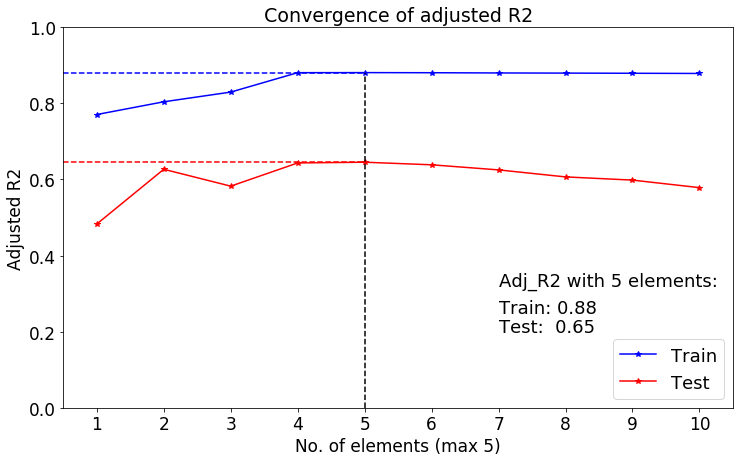

lassocv selected  5  features (ranked decreasingly important): ['x_1' 'x_41' 'x_185' 'x_6' 'x_231']
ensemble selected  5  features (ranked decreasingly important): ['x_40' 'x_6' 'x_1' 'x_185' 'x_41']
y_1
The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
Dropped cols: [ 56   3 209 149  50  97 187  51  32  45]


Boruta performed 100 iterations in 31.40656 secs.
 35 attributes confirmed important: x_107, x_109, x_114, x_118, x_122
and 30 more;
 357 attributes confirmed unimportant: x_0, x_1, x_10, x_100, x_101 and
352 more;
 40 tentative attributes left: x_120, x_133, x_136, x_138, x_151 and 35
more;


lasso selected  5  features (ranked decreasingly important): ['x_162' 'x_59' 'x_114' 'x_125' 'x_171']


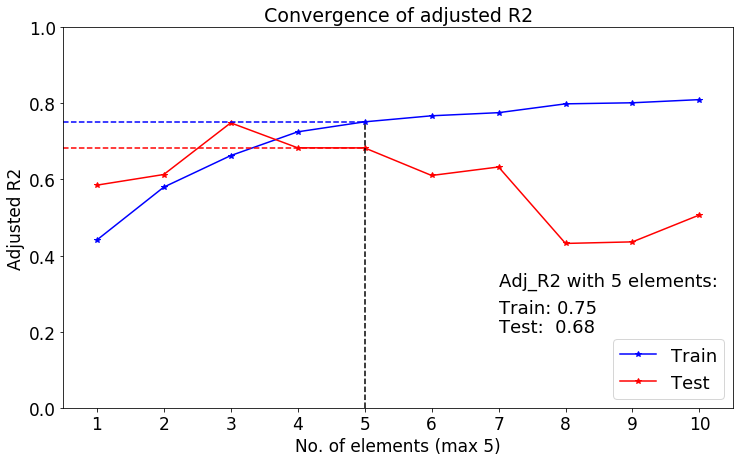

lassocv selected  5  features (ranked decreasingly important): ['x_162' 'x_59' 'x_125' 'x_114' 'x_140']
ensemble selected  5  features (ranked decreasingly important): ['x_125' 'x_114' 'x_60' 'x_407' 'x_88']
y_2
The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
Dropped cols: [ 56   3 209 149  50  97 187  51  32  45]


Boruta performed 100 iterations in 23.70304 secs.
 22 attributes confirmed important: x_109, x_11, x_123, x_127, x_133
and 17 more;
 400 attributes confirmed unimportant: x_0, x_10, x_100, x_101, x_102
and 395 more;
 10 tentative attributes left: x_1, x_113, x_138, x_170, x_237 and 5
more;


lasso selected  4  features (ranked decreasingly important): ['x_226' 'x_109' 'x_6' 'x_358']


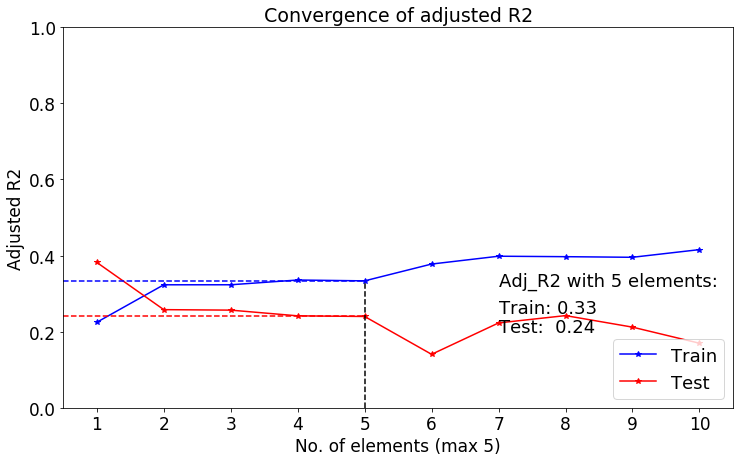

lassocv selected  5  features (ranked decreasingly important): ['x_219' 'x_226' 'x_170' 'x_220' 'x_81']
ensemble selected  5  features (ranked decreasingly important): ['x_226' 'x_221' 'x_84' 'x_127' 'x_295']
y_3
The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
Dropped cols: [ 56   3 209  50  97 187  51  32  45]


Boruta performed 100 iterations in 27.2944 secs.
 22 attributes confirmed important: x_1, x_109, x_118, x_124, x_131 and
17 more;
 373 attributes confirmed unimportant: x_0, x_100, x_101, x_102, x_103
and 368 more;
 38 tentative attributes left: x_10, x_116, x_120, x_136, x_154 and 33
more;


lasso selected  5  features (ranked decreasingly important): ['x_82' 'x_79' 'x_6' 'x_39' 'x_138']


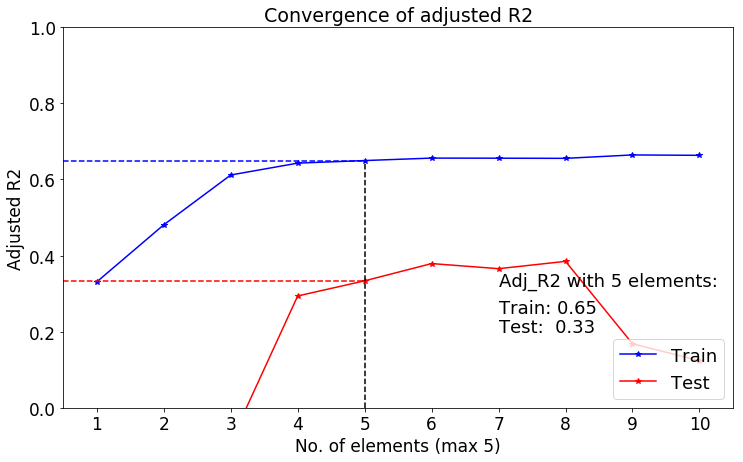

lassocv selected  5  features (ranked decreasingly important): ['x_79' 'x_82' 'x_382' 'x_86' 'x_194']
ensemble selected  5  features (ranked decreasingly important): ['x_138' 'x_6' 'x_133' 'x_79' 'x_360']
R2_train_single
               y_0       y_1       y_2       y_3
Lasso     0.880880  0.751503  0.335836  0.649754
LassoCV   0.880880  0.744935  0.477377  0.544712
ensemble  0.880404  0.702072  0.403383  0.553764
R2_test_single
               y_0       y_1       y_2       y_3
Lasso     0.645403  0.683032  0.241686  0.333695
LassoCV   0.645403  0.704811  0.336008 -0.133416
ensemble  0.639826  0.555810  0.183532  0.250605


In [16]:
R2_train_single, R2_test_single, coeff = main(dx, dy, cat_new, Ltype='long', bs=False, N_pre=100)
print 'R2_train_single'
print R2_train_single
print 'R2_test_single'
print R2_test_single

y_0
The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
Dropped cols: [ 71  11 109  56   3  10   4 209 149 198 146  50  35 187  51  32  45]


Boruta performed 100 iterations in 11.00059 secs.
 11 attributes confirmed important: x_1, x_12, x_133, x_145, x_185 and
6 more;
 401 attributes confirmed unimportant: x_0, x_100, x_101, x_102, x_103
and 396 more;
 13 tentative attributes left: x_127, x_150, x_154, x_179, x_221 and 8
more;


lasso selected  4  features (ranked decreasingly important): ['x_1' 'x_41' 'x_185' 'x_6']


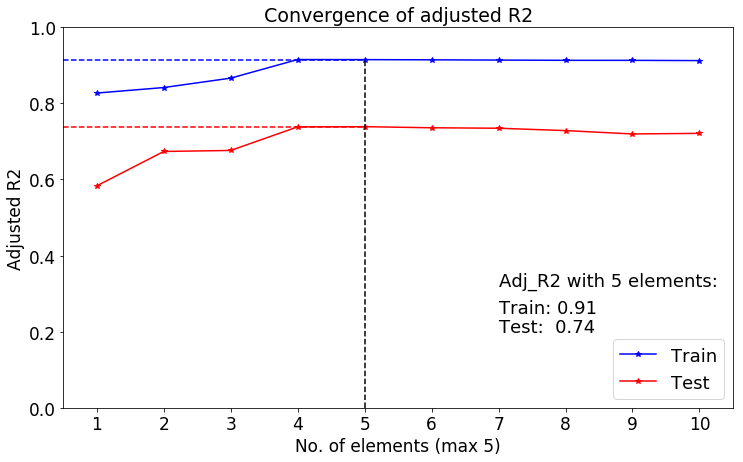

lassocv selected  4  features (ranked decreasingly important): ['x_1' 'x_41' 'x_185' 'x_6']
ensemble selected  5  features (ranked decreasingly important): ['x_1' 'x_185' 'x_40' 'x_6' 'x_41']
y_1
The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
Dropped cols: [ 71  11 109  56   3  10   4 209 149 198 146  50  35 187  51  32  45]


Boruta performed 100 iterations in 14.94857 secs.
 32 attributes confirmed important: x_114, x_118, x_122, x_124, x_125
and 27 more;
 362 attributes confirmed unimportant: x_0, x_1, x_100, x_101, x_102
and 357 more;
 31 tentative attributes left: x_106, x_136, x_138, x_139, x_158 and 26
more;


lasso selected  5  features (ranked decreasingly important): ['x_162' 'x_59' 'x_274' 'x_60' 'x_87']


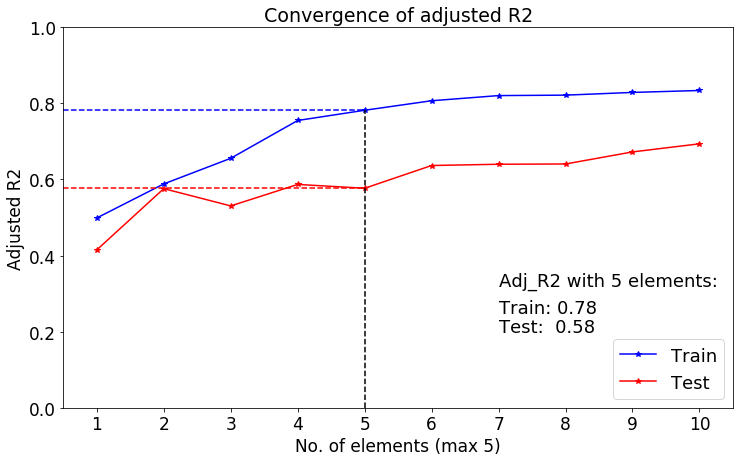

lassocv selected  5  features (ranked decreasingly important): ['x_162' 'x_59' 'x_274' 'x_60' 'x_62']
ensemble selected  5  features (ranked decreasingly important): ['x_60' 'x_53' 'x_39' 'x_162' 'x_407']
y_2
The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
Dropped cols: [ 71  11 109  56   3  10   4 209 149 198 146  50  35 187  51  32  45]


Boruta performed 100 iterations in 12.47553 secs.
 12 attributes confirmed important: x_123, x_127, x_220, x_221, x_226
and 7 more;
 394 attributes confirmed unimportant: x_0, x_1, x_100, x_101, x_103
and 389 more;
 19 tentative attributes left: x_102, x_110, x_124, x_138, x_182 and 14
more;


lasso selected  5  features (ranked decreasingly important): ['x_226' 'x_138' 'x_220' 'x_5' 'x_87']


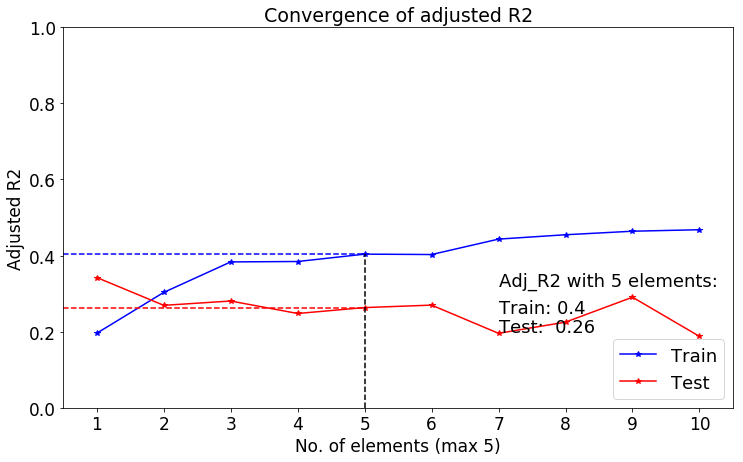

lassocv selected  5  features (ranked decreasingly important): ['x_440' 'x_281' 'x_226' 'x_110' 'x_244']
ensemble selected  5  features (ranked decreasingly important): ['x_270' 'x_127' 'x_221' 'x_38' 'x_123']
y_3
The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
Dropped cols: [ 71  11  56 109   4  10   3  34 209 149 198  50 146  97 187 220   6  51
  32  45]


Boruta performed 100 iterations in 13.33393 secs.
 17 attributes confirmed important: x_1, x_124, x_133, x_156, x_185 and
12 more;
 368 attributes confirmed unimportant: x_0, x_100, x_101, x_102, x_103
and 363 more;
 37 tentative attributes left: x_105, x_116, x_118, x_120, x_138 and 32
more;


lasso selected  5  features (ranked decreasingly important): ['x_382' 'x_222' 'x_6' 'x_87' 'x_58']


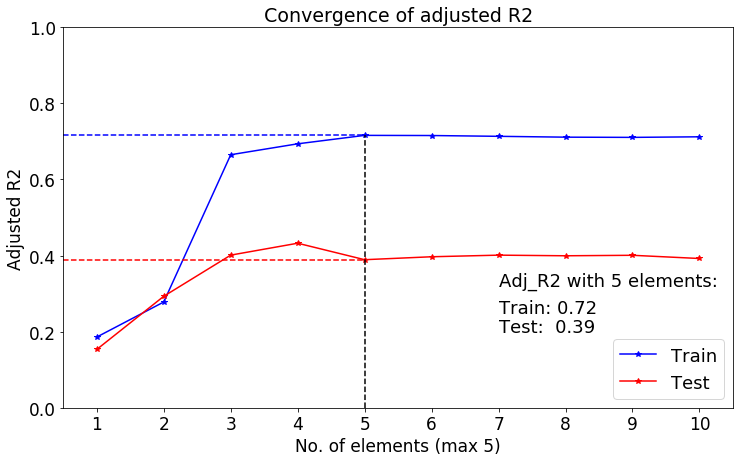

lassocv selected  5  features (ranked decreasingly important): ['x_382' 'x_361' 'x_58' 'x_90' 'x_87']
ensemble selected  5  features (ranked decreasingly important): ['x_25' 'x_1' 'x_363' 'x_60' 'x_185']
R2_train_single
               y_0       y_1       y_2       y_3
Lasso     0.915224  0.781937  0.403811  0.715924
LassoCV   0.915224  0.784999  0.503558  0.478427
ensemble  0.914575  0.663543  0.451067  0.591427
R2_test_single
               y_0       y_1       y_2       y_3
Lasso     0.738316  0.576931  0.263400  0.389211
LassoCV   0.738316  0.640897 -0.328367  0.295686
ensemble  0.733030  0.546159 -0.014270  0.283998


In [17]:
R2_train_single, R2_test_single, coeff = main(dx, dy, cat_new, Ltype='long', test_ratio=0.5, bs=False, N_pre=100)
print 'R2_train_single'
print R2_train_single
print 'R2_test_single'
print R2_test_single